In [12]:
import json

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex

import pandas as pd
import numpy as np
import umap
from openai import OpenAI
import warnings

# Suppress all UserWarnings because umap is annoying
warnings.filterwarnings("ignore", category=UserWarning)

In [32]:
def load_and_prep_names(file_path, sex):
    df = pd.read_json(file_path)
    melted_df = pd.melt(df, var_name="race", value_name="name")
    melted_df.dropna(inplace=True)
    melted_df.reset_index(drop=True, inplace=True)
    melted_df["sex"] = sex
    return melted_df


# File paths
fn_names_men = "https://raw.githubusercontent.com/BloombergGraphics/2024-openai-gpt-hiring-racial-discrimination/main/data/input/top_mens_names.json"
fn_names_women = "https://raw.githubusercontent.com/BloombergGraphics/2024-openai-gpt-hiring-racial-discrimination/main/data/input/top_womens_names.json"

# Load and prepare data
names_men = load_and_prep_names(fn_names_men, "M")
names_women = load_and_prep_names(fn_names_women, "W")

# Combine and title-case names - Original used all upper case
name_df = pd.concat([names_men, names_women])
name_df["name"] = name_df["name"].str.title()

# Now, name_df is ready and contains the processed names with races and sex indicators.
name_df.sample(5)

,race,name,sex
307,H,Alfredo Rosas,M
98,W,Susan Huber,W
375,H,Natalie Vazquez,W
156,B,Keon Washington,M
381,H,Raquel Hernandez,W


In [31]:
def get_open_embeddings(text_list, model="text-embedding-3-small"):
    client = OpenAI(max_retries=3)
    """Fetches embeddings for a list of texts using the specified model."""
    embeddings_response = client.embeddings.create(input=text_list, model=model)
    return [text.embedding for text in embeddings_response.data]


def reduce_dimensions(
    df, embedding_column, n_components=2, random_state=42, n_neighbors=30, min_dist=0.9
):
    """Reduces the dimensions of embeddings to 2D using UMAP."""
    embeddings = np.vstack(df[embedding_column])
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    df[f"{embedding_column}_umap_x"], df[f"{embedding_column}_umap_y"] = (
        reduced_embeddings.T
    )
    return df, reducer


# Main code
for model in [
    "text-embedding-3-small",
]:

    if model not in name_df.keys():
        names = name_df["name"].tolist()
        name_df[model] = get_open_embeddings(names, model=model)
    name_df, umap_reducer = reduce_dimensions(name_df, model)

Finally, plot them. I added gender to the mix by showing women's names with a darker hue.

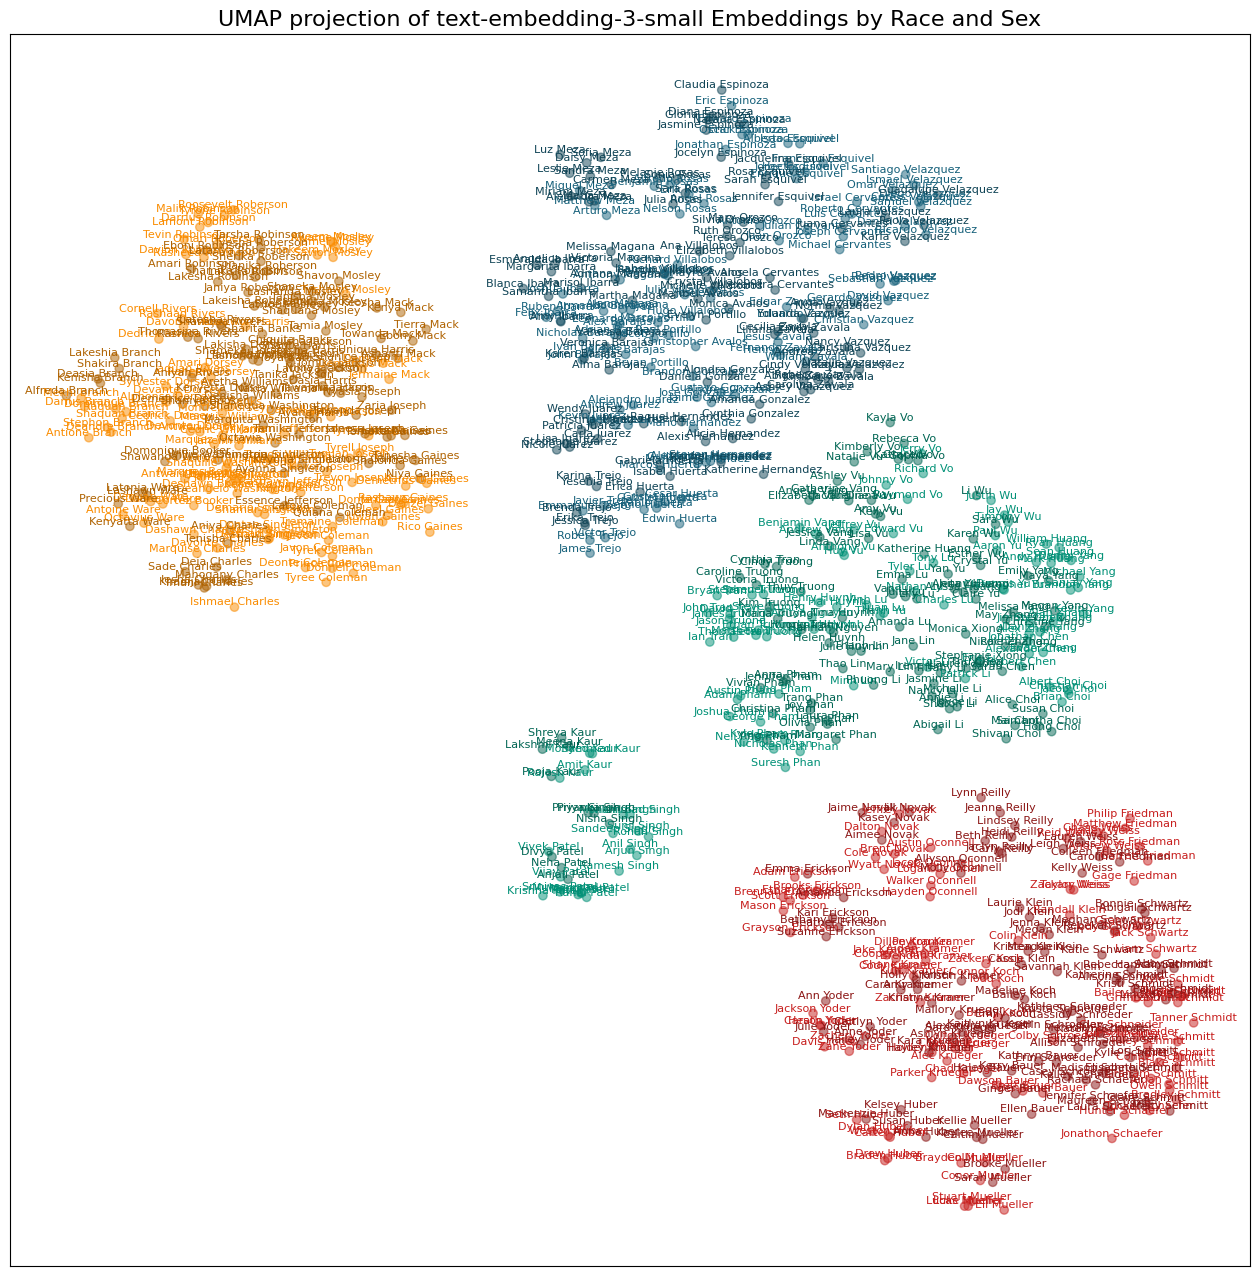

In [17]:
# Function to darken a color
def darken_color(color, factor=0.7):
    # Convert to RGBA if it's a named color or in hex format
    rgba_color = to_rgba(color)
    # Darken by reducing the brightness
    darkened = [factor * rgb for rgb in rgba_color[:3]] + [rgba_color[3]]
    return to_hex(darkened)


# Base colors for races
race2color = {
    "W": "#c71e1d",
    "B": "#fa8c00",
    "A": "#009076",
    "H": "#15607a",
    "CTRL": "grey",
}

def plot_names(model):
    # Extend race2color with darker shades for females
    race2color_female = {race: darken_color(color) for race, color in race2color.items()}

    # Extract UMAP coordinates, names, races, and sexes
    umap_x = name_df[f"{model}_umap_x"].values
    umap_y = name_df[f"{model}_umap_y"].values
    names = name_df["name"].values
    races = name_df["race"].values
    sexes = name_df["sex"].values

    # Determine color based on race and sex
    colors = [
        race2color_female[race] if sex == "W" else race2color[race]
        for race, sex in zip(races, sexes)
    ]

    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.scatter(umap_x, umap_y, color=colors, alpha=0.5)

    # Annotate each point with the corresponding name
    for x, y, name, color in zip(umap_x, umap_y, names, colors):
        ax.annotate(name, (x, y), color=color, size=8, ha="center", va="bottom")

    # Enhancements
    ax.set_title(f"UMAP projection of {model} Embeddings by Race and Sex", fontsize=16)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

    # Optional: Remove the x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()
plot_names('text-embedding-3-small')

In [29]:

# Define a custom aggregation function to compute the average embeddings
def average_embeddings(series):
    return np.mean(np.stack(series), axis=0)

# Group by race and aggregate using the custom function
average_embeddings_by_race = name_df.groupby('race')['text-embedding-3-small'].agg(average_embeddings)


In [79]:
from sklearn.metrics.pairwise import cosine_similarity


s = 'He graduated college with a pre-med degree.'
input_embedding = np.array(get_open_embeddings([s])[0])

# Convert input_embedding to the expected shape (1, -1) for cosine_similarity function
input_embedding_reshaped = input_embedding.reshape(1, -1)

# Calculate cosine similarity with each average embedding
def calculate_similarity(avg_embedding):
    # Reshape the avg_embedding from Series for cosine_similarity
    avg_embedding_reshaped = np.array(avg_embedding).reshape(1, -1)
    return cosine_similarity(input_embedding_reshaped, avg_embedding_reshaped)[0][0]

# Apply the calculate_similarity function across the average embeddings
similarities = average_embeddings_by_race.apply(calculate_similarity)

# Find the race with the highest similarity score
closest_race = similarities.idxmax()

# Output
print(f"The closest race based on the embedding is: {closest_race}")


The closest race based on the embedding is: W


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np







[0.003315205220133066,
 0.002046877285465598,
 -0.033067118376493454,
 -0.008096914738416672,
 0.015423772856593132,
 -0.023373471572995186,
 0.01264930609613657,
 0.009195377118885517,
 0.027857916429638863,
 -0.011901898309588432,
 -0.025253314524888992,
 0.038253676146268845,
 -0.05286209285259247,
 0.040450599044561386,
 0.039703190326690674,
 -0.031051384285092354,
 -0.039703190326690674,
 -0.029443325474858284,
 -0.03999762609601021,
 0.01835678145289421,
 0.0012138293823227286,
 0.005766928195953369,
 -0.033452149480581284,
 0.038502808660268784,
 -0.021051978692412376,
 -0.0054640015587210655,
 0.00717397965490818,
 -0.006030219607055187,
 0.007536359131336212,
 -0.031413763761520386,
 0.042466334998607635,
 -0.039046380668878555,
 0.0481511615216732,
 -0.01717904768884182,
 0.052545011043548584,
 -0.04960067942738533,
 0.004082430154085159,
 0.039476703852415085,
 0.010174933820962906,
 -0.003918227273970842,
 -0.016499586403369904,
 -0.059158436954021454,
 -0.0030972114764153

In [30]:
average_embeddings_by_race

race
A    [0.001702732309640851, -0.010732972649930162, ...
B    [0.011965617387613748, -0.015705888064730972, ...
H    [0.007934465562721016, -0.0028665899064799303,...
W    [-0.005791034655121621, -0.0004508114533291518...
Name: text-embedding-3-small, dtype: object

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'name_df' is your DataFrame and the necessary columns are defined
# For example purposes, let's mock some data
# name_df = ...
embeddings_model = 'text-embedding-3-small'
umap_columns = [f"{embeddings_model}_umap_x", f"{embeddings_model}_umap_y"]


# Prepare the data
X = name_df[umap_columns].values
y_string = name_df['race']  # Labels
le = LabelEncoder()
y = le.fit_transform(y_string)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the SVM classifier
clf = SVC(kernel='rbf')  # You can choose different kernels such as 'rbf', 'poly', etc.

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [22]:
import matplotlib.colors as mcolors


# Plot the decision boundary
# Create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict for each point in the mesh
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



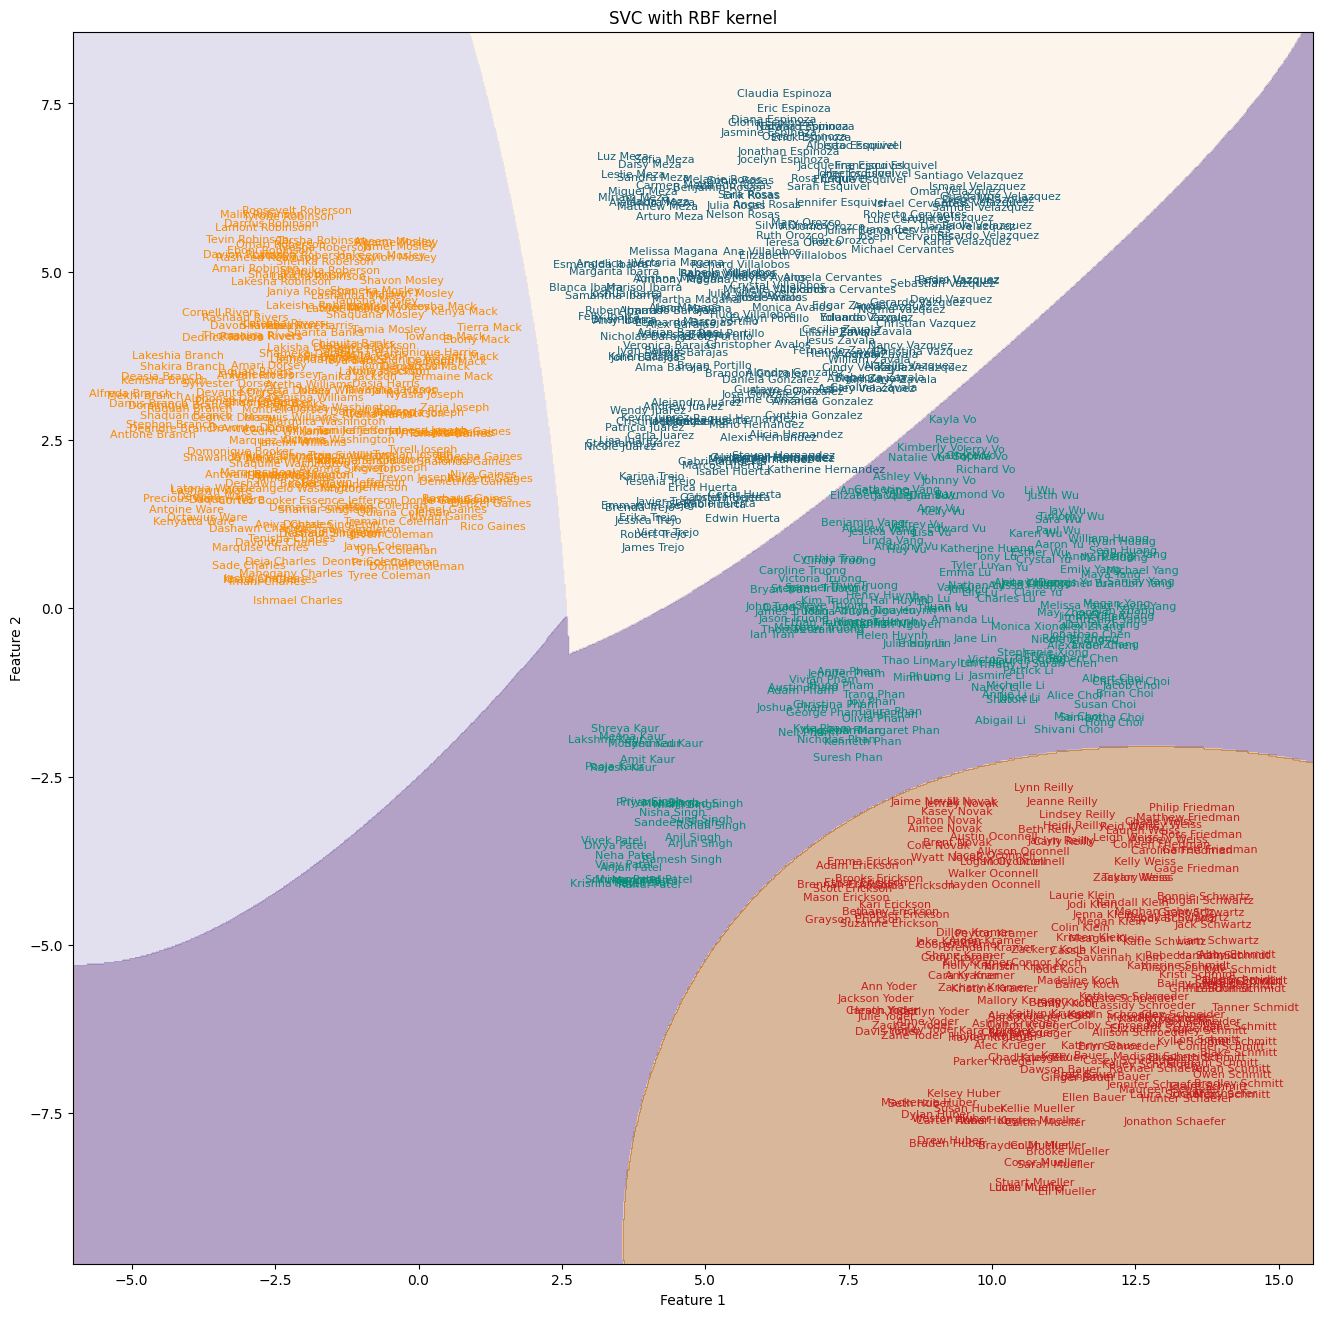

In [23]:

# Define the colors for each race
race2color = {
    "W": "#c71e1d",
    "B": "#fa8c00",
    "A": "#009076",
    "H": "#15607a",
    "CTRL": "grey",
}

# Function to blend color with white to create lighter shade
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.

    Args:
    - color: String or tuple representing the color (e.g., "#c71e1d" or (0.78, 0.10, 0.11)).
    - amount: Float [0, 1] representing the amount to mix with white (0 is original color, 1 is white).

    Returns:
    - Lightened color as a string.
    """
    try:
        c = np.array(mcolors.to_rgb(color))
        white = np.array([1, 1, 1])
        color = white - (white - c) * (1 - amount)
    except ValueError:  # Raised if an invalid color format is provided
        raise ValueError("Invalid color format provided")
    return mcolors.to_hex(color)

# Create lighter colors for plotting
lighter_race2color = {k: lighten_color(v, amount=0.5) for k, v in race2color.items()}



# Create a figure with specific size
fig, ax = plt.subplots(figsize=(16, 16))

# Get unique labels and corresponding colors for contour plot
unique_labels = np.unique(y_train)
contour_colors = [race2color[le.inverse_transform([label])[0]] for label in unique_labels]

# Use contour plot to show the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.PuOr_r, alpha=0.4)

umap_x = name_df[f"{embeddings_model}_umap_x"].values
umap_y = name_df[f"{embeddings_model}_umap_y"].values

# Map the encoded labels back to original string labels and then to specified colors

colors = [race2color[le.inverse_transform([i])[0]] for i in y_train]
colors = [race2color[i] for i in name_df[f"race"].values]
# Plot the training points

for x, y, name, color in zip(umap_x, umap_y, names, colors):
    ax.annotate(name, (x, y), color=color, size=8, ha="center", va="bottom")
        
# Set labels for the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('SVC with RBF kernel')

plt.show()

In [27]:
ne = get_open_embeddings(['New '], model=embeddings_model)
new_point = umap_reducer.transform(ne)
new_point_pred = clf.predict(new_point)
le.inverse_transform([new_point_pred])[0]
print(new_point)

[[-1.0143675   0.12942818]]


In [ ]:
new_point_pred